<a href="https://colab.research.google.com/github/Shahid1993/colab-notebooks/blob/master/smart_compose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing Enron Email Data

In [1]:
#To mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!unzip ./sample_data/enron-email-dataset.zip -d ./sample_data

In [0]:
import pandas as pd

In [0]:
# data = pd.read_csv("./sample_data/emails.csv")
# pd.set_option('display.max_colwidth',-1)
# new = data["message"].str.split("\n", n = 15, expand = True) 

In [0]:
#new.head(2)

In [0]:
#data.head(2)

In [0]:
# data["from"] = new[2]
# data["fromn"] = new[8]
# data["to"] = new[3]
# data["ton"] = new[9]
# data["subject"] = new[4]
# data["msg"] = new[15]
# data.drop(columns =["message"], inplace = True) 
# data.drop(columns =["file"], inplace = True) 

In [0]:
# data.head(2)

In [0]:
# data['from'] = data["from"].apply(lambda val: val.replace("From:",''))
# data['fromn'] = data["fromn"].apply(lambda val: val.replace("X-From:",''))
# data['to'] = data["to"].apply(lambda val: val.replace("To:",''))
# data['ton'] = data["ton"].apply(lambda val: val.replace("X-To:",''))
# data['subject'] = data["subject"].apply(lambda val: val.replace("Subject:",''))
# data['msg'] = data["msg"].apply(lambda val: val.replace("\n",' '))

In [0]:
# data.head(2)

In [0]:
# Lets look only at emails with 100 words or less and that are Non-replies
# data[(data['msg'].str.len() <100) & ~(data['subject'].str.contains('Re:'))].sample(5)

In [0]:
# data.head()['msg']

In [0]:
# corpus = [msg for msg in data[(data['msg'].str.len() <100) & ~(data['subject'].str.contains('Re:'))]['msg']]

In [0]:
# corpus[60:69]

In [0]:
# len(corpus)

In [0]:
#Taking only as subset of corpus, since it takes lot of time for training
# corpus = corpus[0:10000]

file = open("./drive/My Drive/ML/data/smart_compose.txt", 'r')
corpus = [line for line in file]

In [16]:
len(corpus)

158915

In [0]:
from random import sample

corpus = sample(corpus, 2500)

In [18]:
len(corpus)

2500

In [19]:
corpus[60:75]

['A man , woman and three bicycles are resting by a silver car .\n',
 'Several women are wrapping themselves up in pink , blue and white ribbon .\n',
 'A young man takes aim in a carnival game .\n',
 'A woman is smiling holding up a Spiderman shirt .\n',
 'A woman cutting fabric flowers in a market .\n',
 'There is a carpenter measuring a board .\n',
 'Two construction workers are sitting up on the side of a building .\n',
 '2 men and a woman who is wearing red are holding a surfboard standing in the sand .\n',
 'a surfer is riding the waves whilst another surfer sits on his board waiting .\n',
 'Field workers are working in a rice paddy .\n',
 'A motorcyclist is riding their sponsored car along a roadway that has recently turned .\n',
 'A young boy with a shaved head and dirty white collared shirt holds a chicken in his arm .\n',
 'Man and woman and others , with scary , gory makeup and holding fake brain walking down the street .\n',
 'A construction worker sits in a green lift .\n',

In [20]:
# Start by importing all the things we'll need.
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, CuDNNLSTM, Flatten, TimeDistributed, Dropout, LSTMCell, RNN, Bidirectional, Concatenate, Layer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import tf_utils
from tensorflow.keras import backend as K

import unicodedata
import re
import numpy as np
import os
import time
import shutil

import pandas as pd
import numpy as np
import string, os 
tf.__version__

'1.14.0'

In [0]:
def clean_special_chars(text, punct):
    for p in punct:
        text = text.replace(p, '')
    return text

      
def preprocess(data):
    output = []
    punct = '#$%&*+-/<=>@[\\]^_`{|}~\t\n'
    for line in data:
         pline= clean_special_chars(line.lower(), punct)
         output.append(pline)
    return output  


def generate_dataset():
  
    processed_corpus = preprocess(corpus)    
    output = []
    for line in processed_corpus:
        token_list = line
        for i in range(1, len(token_list)):
            data = []
            x_ngram = '<start> '+ token_list[:i+1] + ' <end>'
            y_ngram = '<start> '+ token_list[i+1:] + ' <end>'
            data.append(x_ngram)
            data.append(y_ngram)
            output.append(data)
    print("Dataset prepared with prefix and suffixes for teacher forcing technique")
    dummy_df = pd.DataFrame(output, columns=['input','output'])
    return output, dummy_df            

In [0]:
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
        self.vocab = sorted(self.vocab)
        self.word2idx["<pad>"] = 0
        self.idx2word[0] = "<pad>"
        for i,word in enumerate(self.vocab):
            self.word2idx[word] = i + 1
            self.idx2word[i+1] = word

def max_length(t):
    return max(len(i) for i in t)

def load_dataset():
    pairs,df = generate_dataset()
    out_lang = LanguageIndex(sp for en, sp in pairs)
    in_lang = LanguageIndex(en for en, sp in pairs)
    input_data = [[in_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    output_data = [[out_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]

    max_length_in, max_length_out = max_length(input_data), max_length(output_data)
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_data, maxlen=max_length_in, padding="post")
    output_data = tf.keras.preprocessing.sequence.pad_sequences(output_data, maxlen=max_length_out, padding="post")
    return input_data, output_data, in_lang, out_lang, max_length_in, max_length_out, df


In [23]:
input_data, teacher_data, input_lang, target_lang, len_input, len_target, df = load_dataset()


target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))

# Shuffle all of the data in unison. This training set has the longest (e.g. most complicated) data at the end,
# so a simple Keras validation split will be problematic if not shuffled.

p = np.random.permutation(len(input_data))
input_data = input_data[p]
teacher_data = teacher_data[p]
target_data = target_data[p]

Dataset prepared with prefix and suffixes for teacher forcing technique


In [24]:
pd.set_option('display.max_colwidth', -1)
BUFFER_SIZE = len(input_data)
BATCH_SIZE = 128
embedding_dim = 300
units = 128
vocab_in_size = len(input_lang.word2idx)
vocab_out_size = len(target_lang.word2idx)
df.iloc[30:65]

,input,output
30,<start> people hang upside down as a rol <end>,<start> ler coaster executes a spiral looptheloop . <end>
31,<start> people hang upside down as a roll <end>,<start> er coaster executes a spiral looptheloop . <end>
32,<start> people hang upside down as a rolle <end>,<start> r coaster executes a spiral looptheloop . <end>
33,<start> people hang upside down as a roller <end>,<start> coaster executes a spiral looptheloop . <end>
34,<start> people hang upside down as a roller <end>,<start> coaster executes a spiral looptheloop . <end>
35,<start> people hang upside down as a roller c <end>,<start> oaster executes a spiral looptheloop . <end>
36,<start> people hang upside down as a roller co <end>,<start> aster executes a spiral looptheloop . <end>
37,<start> people hang upside down as a roller coa <end>,<start> ster executes a spiral looptheloop . <end>
38,<start> people hang upside down as a roller coas <end>,<start> ter executes a spiral looptheloop . <end>
39,<start> people hang upside down as a roller coast <end>,<start> er executes a spiral looptheloop . <end>


In [25]:
# Create the Encoder layers first.
encoder_inputs = Input(shape=(len_input,))
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim)

# Use this if you dont need Bidirectional LSTM
# encoder_lstm = CuDNNLSTM(units=units, return_sequences=True, return_state=True)
# encoder_out, state_h, state_c = encoder_lstm(encoder_emb(encoder_inputs))

encoder_lstm = Bidirectional(CuDNNLSTM(units=units, return_sequences=True, return_state=True))
encoder_out, fstate_h, fstate_c, bstate_h, bstate_c = encoder_lstm(encoder_emb(encoder_inputs))
state_h = Concatenate()([fstate_h,bstate_h])
state_c = Concatenate()([bstate_h,bstate_c])
encoder_states = [state_h, state_c]


# Now create the Decoder layers.
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = CuDNNLSTM(units=units*2, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)
# Two dense layers added to this model to improve inference capabilities.
decoder_d1 = Dense(units, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
decoder_out = decoder_d2(Dropout(rate=.2)(decoder_d1(Dropout(rate=.2)(decoder_lstm_out))))


# Finally, create a training model which combines the encoder and the decoder.
# Note that this model has three inputs:
model = Model(inputs = [encoder_inputs, decoder_inputs], outputs= decoder_out)

# We'll use sparse_categorical_crossentropy so we don't have to expand decoder_out into a massive one-hot array.
# Adam is used because it's, well, the best.

model.compile(optimizer=tf.train.AdamOptimizer(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 73)]         0                                            
__________________________________________________________________________________________________

In [26]:
# Note, we use 20% of our data for validation.
epochs = 50
history = model.fit([input_data, teacher_data], target_data,
                 batch_size= BATCH_SIZE,
                 epochs=epochs,
                 validation_split=0.2)

Train on 125222 samples, validate on 31306 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
125222/125222 [==============================] - 358s 3ms/sample - loss: 0.6909 - sparse_categorical_accuracy: 0.9061 - val_loss: 0.4741 - val_sparse_categorical_accuracy: 0.9175
Epoch 2/50
125222/125222 [==============================] - 355s 3ms/sample - loss: 0.4220 - sparse_categorical_accuracy: 0.9223 - val_loss: 0.3443 - val_sparse_categorical_accuracy: 0.9321
Epoch 3/50
125222/125222 [==============================] - 355s 3ms/sample - loss: 0.3159 - sparse_categorical_accuracy: 0.9359 - val_loss: 0.2499 - val_sparse_categorical_accuracy: 0.9487
Epoch 4/50
125222/125222 [==============================] - 359s 3ms/sample - loss: 0.2417 - sparse_categorical_accuracy: 0.9484 - val_loss: 0.1933 - val_sparse_categorical_accuracy: 0.9597
Epoch 5/50
125222/125222 [==============================] - 356s 3ms/sample - loss: 0.1938 - sp

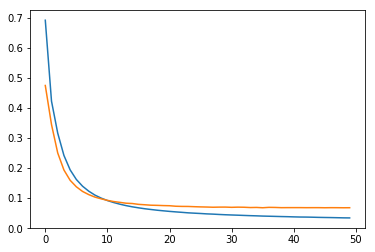

In [27]:
# Plot the results of the training.
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.show()

In [0]:


# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_out, state_h, state_c])

# Generate a new set of tensors for our new inference decoder. Note that we are using new tensors, 
# this does not preclude using the same underlying layers that we trained on. (e.g. weights/biases).

inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")
# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units*2,), name="state_input_h")
state_input_c = Input(shape=(units*2,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))
inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])



In [0]:
# Converts the given sentence (just a string) into a vector of word IDs
# Output is 1-D: [timesteps/words]

def sentence_to_vector(sentence, lang):

    pre = sentence
    vec = np.zeros(len_input)
    sentence_list = [lang.word2idx[s] for s in pre.split(' ')]
    for i,w in enumerate(sentence_list):
        vec[i] = w
    return vec

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
def translate(input_sentence, infenc_model, infmodel):
    sv = sentence_to_vector(input_sentence, input_lang)
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vec = target_lang.word2idx["<start>"]
    stop_vec = target_lang.word2idx["<end>"]
    
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "<start>"
    output_sentence = ""

    while cur_word != "<end>" and i < (len_target-1):
        i += 1
        if cur_word != "<start>":
            output_sentence = output_sentence + " " + cur_word
        x_in = [cur_vec, sh, sc]
        [nvec, sh, sc] = infmodel.predict(x=x_in)
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = target_lang.idx2word[np.argmax(nvec[0,0])]
    return output_sentence

In [43]:
#Note that only words that we've trained the model on will be available, otherwise you'll get an error.


# test = [
#     'hi there',
#     'hell',
#     'have a nice we',
#     'let me ',
#     'Let me kno',
#     'this soun',
#     'is this call going t',
#     'A man si',
#     'Dog bar',
#     'blue sky',
#     'book on a ta',
#     'A man completes the fini',
#     'A man holds a lar',
#     'A young adult wea'
# ]

test = [
    'A woman wearing a bl',
    'A man wor',
    'A man is instr',
    'A city str',
    'A large man wea',
    'Man remov',
    'Seve',
    'person is atte',
    'wearing je',
    'standing out',
    'people in different co',
    'dog ru',
    'biker is ri',
    'Blond girl in a yel',
    'A person is walking al',
    'A you',
    'A young fem',
    'A young female i',
    'A young female is si',
    'A young female is sitting i',
    'A young female is sitting in a c',
    'A young female is sitting in a chair o',
    'A young female is sitting in a chair on th',
    'A young female is sitting in a chair on the be',
    'A young female is sitting in a chair on the beach , wh'
]
  

import pandas as pd
output = []  
for t in test:  
  output.append({"Input seq":t.lower(), "Pred. Seq":translate(t.lower(), encoder_model, inf_model)})

results_df = pd.DataFrame.from_dict(output) 
results_df.head(len(test))

,Input seq,Pred. Seq
0,a woman wearing a bl,d hat and a young man wearing jean shorts and a gray tshirt are standing in front of a basketball carnival game on a blue and yellow checkered floor .
1,a man wor,ng in a skateboard jumping from a short ledge onto the sidewalk .
2,a man is instr,st riding a bike while wearing a helmet .
3,a city str,ntain with a blue shirt on his bmx bicycle .
4,a large man wea,"r wearing a hat , and riding in a motorized wheelchair , is picking out shoes at a store ."
5,man remov,ng men in a city
6,seve,"men wearing a large hat , are assembled outdoors ."
7,person is atte,en down a walkway at a house .
8,wearing je,rs in plaid shirt scaling rocks .
9,standing out,man in a suit wearing a green straw .


In [42]:
# This is to save the model for the web app to use for generation
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = inf_model.to_json()


with open("./drive/My Drive/ML/data/model_num_smart_compose_2500_50.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
inf_model.save_weights("./drive/My Drive/ML/data/model_num_smart_compose_2500_50.h5")

Using TensorFlow backend.


# Loading Existing Model for Prediction

In [0]:
#To mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Start by importing all the things we'll need.
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, CuDNNLSTM, Flatten, TimeDistributed, Dropout, LSTMCell, RNN, Bidirectional, Concatenate, Layer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import tf_utils
from tensorflow.keras import backend as K

import unicodedata
import re
import numpy as np
import os
import time
import shutil

import pandas as pd
import numpy as np
import string, os 
tf.__version__

'1.14.0'

In [0]:
#from keras.models import model_from_json
from tensorflow.keras.models import model_from_json
from keras.models import load_model

In [0]:
# load json and create model
json_file = open('./drive/My Drive/ML/data/model_num.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("./drive/My Drive/ML/data/model_num.h5")
print("Loaded model from disk")

InvalidArgumentError: ignored

In [0]:

# load json and create model
json_file = open('./drive/My Drive/ML/data/model_num.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("./drive/My Drive/ML/data/model_num.h5")
print("Loaded model from disk")

W0906 06:30:03.488031 139718867613568 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0906 06:30:03.497553 139718867613568 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0906 06:30:03.498520 139718867613568 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init

Loaded model from disk


In [0]:
# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_out, state_h, state_c])

NameError: ignored

In [0]:
#Note that only words that we've trained the model on will be available, otherwise you'll get an error.

# test = [
#     'hi there',
#     'hell',
#     'presentation please fin',
#     'resignation please find at',
#     'resignation please ',
#     'have a nice we',
#     'let me ',
#     'promotion congrats ',
#     'christmas Merry ',
#     'please rev',
#     'please ca',
#     'thanks fo',
#     'Let me kno',
#     'Let me know if y',
#     'this soun',
#     'is this call going t'
# ]

test = [
    'A woman wearing a bl',
    'A man wor',
    'A man is instr',
    'A city str',
    'A large man wea',
    'Man remov',
    'Seve',
    'person is atte',
    'wearing je',
    'standing out',
    'people in different co',
    'dog ru',
    'biker is ri',
    'Blond girl in a yel',
    'A person is walking al',
    'A you',
    'A young fem',
    'A young female i',
    'A young female is si',
    'A young female is sitting i',
    'A young female is sitting in a c',
    'A young female is sitting in a chair o',
    'A young female is sitting in a chair on th',
    'A young female is sitting in a chair on the be',
    'A young female is sitting in a chair on the beach , wh'
]
  
import pandas as pd
output = []  
for t in test:  
  output.append({"Input seq":t.lower(), "Pred. Seq":translate(t.lower(), encoder_model, loaded_model)})
  
results_df = pd.DataFrame.from_dict(output) 
results_df.head(len(test))